# Programming Exercise 4: Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand written digit recognition.

## Neural Networks

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

### 1.1 Visualizing the data

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io


In [6]:
# this is the same dataset as used in Ex 3. 
# there are 5000 training examples of 20 x 20 pixel arrays

datamatrix = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex3/ex3/ex3data1.mat')

X, y = datamatrix['X'], datamatrix['y']
X_orig = X
X = np.insert(X, 0, 1, axis = 1) # insert a row of 1s for theta0
theta = np.zeros((X.shape[1],1))

X.shape, y.shape, theta.shape

((5000, 401), (5000, 1), (401, 1))

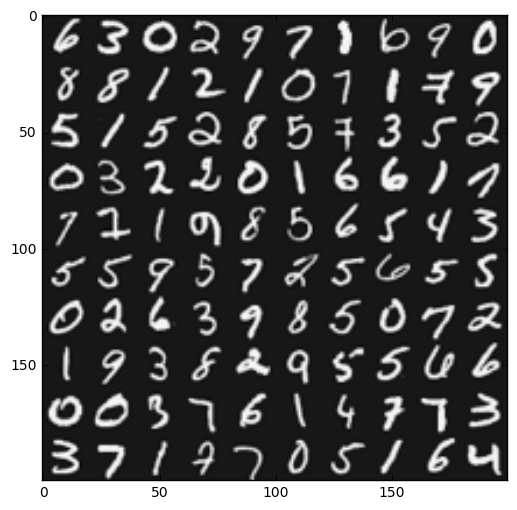

In [8]:
# randomly pick 100 rows from X and display in a 10 x 10 grid
from math import sqrt 
from math import floor, ceil
import matplotlib.cm as cm 

def DisplayData(X):
    # create random set of 100 training images
    rand = X[np.random.randint(X.shape[0], size=100), :]
    
    # size of each image
    example_width, example_height = 20, 20
    # number of images in large array
    display_rows, display_cols = 10, 10
    # setup blank display
    display_array = np.zeros((example_height*display_rows, example_width*display_cols))
    
    row, col = 0, 0
    for image in range(100):
        if col == display_cols:
            row +=1
            col = 0
        squareimg = rand[image].reshape(20,20).T
        display_array[row*example_height:row*example_height+squareimg.shape[0], col*example_width:col*example_width + squareimg.shape[1]] = squareimg
        col += 1

    fig = plt.figure(figsize = (6,6))
    img = scipy.misc.toimage(display_array)
    plt.imshow(img, cmap = cm.Greys_r)

a = DisplayData(X_orig)

### 1.2 Model representation

Our neural network will have 3 layers - an input layer, a hidden layer, and an output layer. Our inputs are pixel values of images with 20 x 20 pixels, so we have 400 input layer units (not counting the extra bias unit which always outputs '1').

In [9]:
# load pre-trained network parameters theta1, theta2

thetamatrix = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex3/ex3/ex3weights.mat')
theta1, theta2 = thetamatrix['Theta1'], thetamatrix['Theta2']

theta1.shape, theta2.shape

((25, 401), (10, 26))

### 1.3 Feedforward and cost function

implement the cost function and gradient for the neural network

In [446]:
# initialize parameters
input_s    = 400       # 20x20 pixel grid for each image
hidden_s   = 25        # hidden layer size
num_labels = 10        # 10 labels, from 1 to 10 ('0' == 10 here)

In [175]:
def sigmoid(z):
    sig = 1. / (1+ np.exp(-z))
    return sig

In [183]:
#unroll theta1 and theta2 parameters into one long array

def unroll(t1, t2):
    ttparams = np.hstack((t1.ravel(), t2.ravel()))
    return ttparams


In [188]:
# reroll long array into distinct theta1 and theta2 parameters

def reroll(ttparams, hidden_s, input_s, num_labels):

    t1split = ttparams[0:(hidden_s*(input_s+1))]
    t1 = np.reshape(t1split, (hidden_s, input_s+1))
    t2split = ttparams[(hidden_s*(input_s+1)):]
    t2 = np.reshape(t2split, (num_labels, hidden_s+1))
    
    return t1,t2

### 1.4 Regularized cost function

Here, we are assuming that the neural network will have only 3 layers - an input layer, a hidden layer, and an output layer.

However, the code should work for any number of input units, hidden units, and ouput units

In [448]:
def nnCostFunction(params, hidden_s, input_s, num_labels, X, y, lamb):
    
    t1, t2 = reroll(params, hidden_s, input_s, num_labels) #return theta1,2
    m = X.shape[0]   # number of training examples
    J = 0            # initialize cost = 0
    a1 = X           # we already inserted X with an array of 1's @ position 0
    z2 = np.dot(a1, t1.T)               # returns a 5000 X 25 array
    sz2 = sigmoid(z2)
    a2 = np.insert(sz2, 0, 1, axis = 1) # 50000 x 26 
    z3 = np.dot(a2, t2.T)               # returns a 5000 x 10 array
    htheta = sigmoid(z3)                # 5000 x 10
    ymat = pd.get_dummies(y.ravel()).as_matrix() # 5000 x 10

    J = -1*(1./m)*np.sum((np.log(htheta)*(ymat)+np.log(1-htheta)*(1-ymat))) + \
        (lamb/(2.*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    
    
    # calculate first gradient
    delta3 = htheta - ymat # 5000x10
    
    # backpropagate gradients:
    delta2 = np.dot(t2[:,1:].T,delta3.T)*sigmoidGradient(z2).T # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = np.dot(delta2,a1) # 25x5000 * 5000x401 = 25x401
    delta2 = np.dot(delta3.T, a2) # 10x5000 *5000x26 = 10x26
    
    theta1_reg = np.c_[np.ones((t1.shape[0],1)),t1[:,1:]]
    theta2_reg = np.c_[np.ones((t2.shape[0],1)),t2[:,1:]]
    
    t1_grad = delta1/m + (theta1_reg*lamb)/m
    t2_grad = delta2/m + (theta2_reg*lamb)/m
    
    grad = unroll(t1_grad, t2_grad) 
    #return J, grad
    return J

In [383]:
# unroll params for input into costFunction:
nn_params = unroll(theta1, theta2)

In [384]:
# cost for lambda = 0 : 0.287629
cost, grad = nnCostFunction(nn_params, hidden_s, input_s, num_labels, X, y, 0)
print cost

0.287629165161


In [442]:
# cost for lambda = 1 : 0.383770
cost, grad = nnCostFunction(nn_params, hidden_s, input_s, num_labels, X, y, 1)
print cost

0.383769859091


## 2. Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. 

### 2.1 Sigmoid gradient
Try the sigmoid gradient function, to get started.
Should large values of z, the gradient should be 0.
When z = 0, the gradient should be exactly 0.25

In [260]:
def sigmoidGradient(z):
    grad = sigmoid(z)*(1-sigmoid(z))
    return grad

In [262]:
a = sigmoidGradient(-100)
b = sigmoidGradient(100)
c = sigmoidGradient(0)
a,b,c

(3.7200759760208356e-44, 0.0, 0.25)

### 2.2 Random initialization

When training neural networks, it's important to randomly initialize the parameters for symmetry breaking.

One effective strategy for choosing epsilon is to base it on the number of units in the network. A good choice is = sqrt(6)/(sqrt(Lin + Lout)) where Lin and Lout are the number of units in the layers adjacent to theta.

In [331]:
# randomly initialize weights of theta1 and theta2
def randInitWeights(a, b):
    epsilon_init = 0.12
    weights_shape = (a, b+1)
    
    rand_weights = np.random.rand( *weights_shape ) * 2 * epsilon_init - epsilon_init    
    return rand_weights

rand_theta1 = randInitWeights(hidden_s, input_s)
rand_theta2 = randInitWeights(num_labels, hidden_s)
rand_theta1.shape, rand_theta2.shape

((25, 401), (10, 26))

### 2.3 Backpropagation

Recall that the intuition behind the backpropagation algorithm is as follows:

Given a training example (x(t), y(t)), we will first run a 'forward pass' to compute all the activations throught the network, including the output value of the hypothesis, htheta(x). Then, for each node j in layer l, we would like to compute and error term, sigma(j)(l) that measures how much that node was 'responsible' for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define sigma(j)(3) (since 3 is the output layer). For the hidden units, you will compute sigma(j)(l) based on a weighted average of the error terms of the nodes in a layer (l+1).

In [447]:
def backpropagate(params, hidden_s, input_s, num_labels, X, y, lamb):
    
    t1, t2 = reroll(params, hidden_s, input_s, num_labels) #return theta1,2
    m = X.shape[0]   # number of training examples

    a1 = X           # we already inserted X with an array of 1's @ position 0
    z2 = np.dot(a1, t1.T)               # returns a 5000 X 25 array
    sz2 = sigmoid(z2)
    a2 = np.insert(sz2, 0, 1, axis = 1) # 50000 x 26 
    z3 = np.dot(a2, t2.T)               # returns a 5000 x 10 array
    htheta = sigmoid(z3)                # 5000 x 10
    ymat = pd.get_dummies(y.ravel()).as_matrix() # 5000 x 10

    # calculate first gradient
    delta3 = htheta - ymat # 5000x10
    
    # backpropagate gradients:
    delta2 = np.dot(t2[:,1:].T,delta3.T)*sigmoidGradient(z2).T # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = np.dot(delta2,a1) # 25x5000 * 5000x401 = 25x401
    delta2 = np.dot(delta3.T, a2) # 10x5000 *5000x26 = 10x26
    
    theta1_reg = np.c_[np.ones((t1.shape[0],1)),t1[:,1:]]
    theta2_reg = np.c_[np.ones((t2.shape[0],1)),t2[:,1:]]
    
    t1_grad = delta1/m + (theta1_reg*lamb)/m
    t2_grad = delta2/m + (theta2_reg*lamb)/m
    #return t1_grad, t2_grad
    
    #unroll grad into 1 vector
    out = unroll(t1_grad, t2_grad)
    return out

In [330]:
grad1, grad2 = backpropagate(nn_params, hidden_s, input_s, num_labels, X, y, 0)
grad1.shape, grad2.shape

((25, 401), (10, 26))

### 2.4 Gradient checking

We can implement a function to compute the numerical gradient. We will create a small neural network and dataset that will be used for checking the gradients.

If the backpropagation implementation is correct, you should see a relative difference that is less than 1e-9

In [439]:
def computeNumericalGradient(J, theta, hidden_s, input_s, num_labels, X, y, lamb):
    numgrad = np.zeros((theta.size))
    perturb = np.zeros((theta.size))
    e = 1e-4
    for i in range(theta.shape[0]):
        # set a perturbation vector
        perturb[i] = e
        loss1 = J(theta - perturb, hidden_s, input_s, num_labels, X, y, 0)[0]
        loss2 = J(theta + perturb, hidden_s, input_s, num_labels, X, y, 0)[0]
        
        # compute numerical gradient
        numgrad[i] = (loss2 - loss1) / (2*e)
        perturb[i] = 0
    
    return numgrad

In [435]:
def checkNNGradients():
    # initialize NN parameters
    input_s    = 3
    hidden_s   = 5
    num_labels = 3
    m          = 5
    
    # generate random test data
    theta1 = randInitWeights(hidden_s, input_s)
    theta2 = randInitWeights(num_labels, hidden_s)

    # we can also use randInitWeights to generate X
    X = randInitWeights(m, input_s - 1)
    X = np.insert(X, 0, 1, axis = 1)
    y = 1 + np.mod(range(m), num_labels)

    # unroll parameters
    nn_params = unroll(theta1, theta2)
    
    cost, grad = nnCostFunction(nn_params, hidden_s, input_s, num_labels, X, y, 0)
    numgrad = computeNumericalGradient(nnCostFunction, nn_params, hidden_s, input_s, num_labels, X, y, 0)

    # visually examine the two gradient computations. 
    d = {'Grad': grad, 'Num_Grad': numgrad, 'Diff': numgrad-grad}
    df = pd.DataFrame(data=d, index=None)
    relative_diff = np.sum(d['Diff'])
    
    print 'The relative difference is: ' + str(relative_diff)
    return df

In [440]:
df = checkNNGradients()
df[0:10]

The relative difference is: -7.19501939582e-11


,Diff,Grad,Num_Grad
0,4.644037e-13,-0.003972,-0.003972
1,-6.318827e-13,0.000350,0.000350
2,-2.671854e-12,-0.000399,-0.000399
3,-2.200004e-12,0.000428,0.000428
4,2.767461e-12,-0.001295,-0.001295
5,-1.194223e-12,-0.000431,-0.000431
6,7.463278e-13,0.000586,0.000586
7,-6.977358e-13,-0.000450,-0.000450
8,1.559300e-12,-0.003012,-0.003012
9,8.142579e-13,-0.000033,-0.000033


### 2.5 Regularized Neural Networks

The cost function above is already regularized.

### 2.6 Learning parameters 

scipy's optimize.minimize function will be used to learn a good set of parameters. If the implementation is correct, you should see a reported training accuracy of about 95.3%. With longer iterations and optimized lambda values, it is possible to get the neural network to perfectly fit the training set.

In [463]:
import scipy
#from scipy.optimize import minimize

def trainNNparams(hidden_s, input_s, num_labels, X, y, lamb):
    # generate random thetas
    rand_theta1 = randInitWeights(hidden_s, input_s)
    rand_theta2 = randInitWeights(num_labels, hidden_s)
    
    # unroll thetas
    initial_rand_theta = unroll(rand_theta1, rand_theta2)
    results = scipy.optimize.fmin_cg(nnCostFunction, initial_rand_theta, backpropagate, \
                                     args=(hidden_s, input_s, num_labels, X, y, lamb), maxiter=1000, \
                                     disp=True, full_output=True)
    return results

In [464]:
optim_thetas = trainNNparams(hidden_s, input_s, num_labels, X, y, 1)

         Current function value: 0.219108
         Iterations: 425
         Function evaluations: 1488
         Gradient evaluations: 1473


In [475]:
optim_thetas[0].shape

(10285,)

In [476]:
def nnPredict(optim_thetas, hidden_s, input_s, num_labels, X):
    theta1, theta2 = reroll(optim_thetas, hidden_s, input_s, num_labels)       
    m = X.shape[0]             # number of training examples
    n = theta2.shape[0]        # number of labels / categories to predict
    predict = np.zeros((m,1))  # initialize empty array of predictions
    a1 = X                     # we had already inserted 1 into position 0
    z2 = np.dot(theta1, a1.T)
    a2 = np.c_[np.ones((m,1)), sigmoid(z2).T]
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    
    predict = np.argmax(a3, axis =1)+1
    return predict

nnPrediction = nnPredict(optim_thetas[0], hidden_s, input_s, num_labels, X)
print 'Training set accuracy: {} %'.format(np.mean(nnPrediction == y.ravel())*100)

Training set accuracy: 99.66 %


## 3. Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize the representations captured by the hiddne units. One way to visualize the 'representation' capture by the hidden unit is to reshape the 400 dimensional vector (after discarding the 1 dimensional bias term) into a 20 x 20 image and display it.

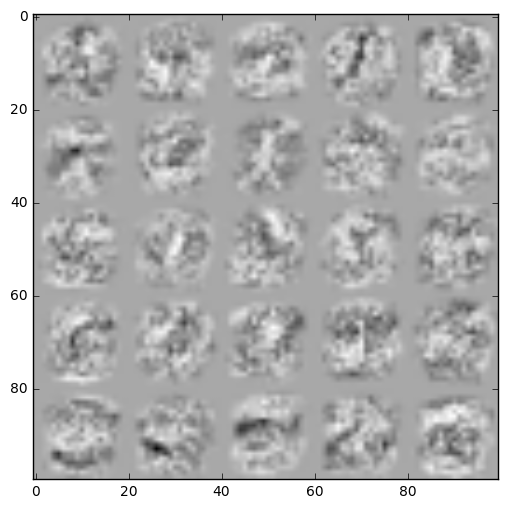

In [483]:
opt_theta1, opt_theta2 = reroll(optim_thetas[0], hidden_s, input_s, num_labels)       
# opt_theta1[:,1:] = 25 x 400 matrix

def DisplayHidden(X):
    # size of each image
    example_width, example_height = 20, 20
    # number of images in large array
    display_rows, display_cols = 5, 5
    # setup blank display
    display_array = np.zeros((example_height*display_rows, example_width*display_cols))
    
    row, col = 0, 0
    for image in range(25):
        if col == display_cols:
            row +=1
            col = 0
        squareimg = X[image].reshape(20,20).T
        display_array[row*example_height:row*example_height+squareimg.shape[0], col*example_width:col*example_width + squareimg.shape[1]] = squareimg
        col += 1

    fig = plt.figure(figsize = (6,6))
    img = scipy.misc.toimage(display_array)
    plt.imshow(img, cmap = cm.Greys_r)

a = DisplayHidden(opt_theta1[:,1:])